In [1]:
#
# Analysis of the BlockScience Labs: Uniswap model (WIP)
#
# Maintainer: Tyler Mace <tyler@blocksciencelabs.com>
# Notes: This notebook does not perform execution of the model -- only
#        analysis of the resulting data.
#

In [2]:
# Third party
from datetime import datetime
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys

# From our model work
sys.path.append("/home/jovyan/cadcad-uniswap")
from model.state import genesis_state
from model.utils.plot_utils import plot_fee_impact, plot_agenttype_return
from model.utils.post_processing import add_trading_volume

In [3]:
# Print a timestamp so we have context with our analysis
print("Execution Date:", datetime.now().strftime("%d/%b/%Y %H:%M UTC"))

Execution Date: 18/Oct/2022 03:55 UTC


In [4]:
plt.style.use('dark_background')
uniswap_events = pd.read_pickle('../data/simpler_uniswap_events.p')
sys_params = {'retail_precision': [3,3,15,15,
                3,3,15,15],
                  'retail_tolerance': [0.0005, 0.025, 0.0005, 0.025,
                        0.0005, 0.025, 0.0005, 0.025],
                  'fee_numerator': [997, 997, 997, 997,
                        995, 995, 995, 995],
                 'uniswap_events':[uniswap_events]}

In [5]:
fees = [(1-(param/1000))*100 for param in sys_params['fee_numerator']]
retail_tols = [param*100 for param in sys_params['retail_tolerance']]
retail_precision = [param for param in sys_params['retail_precision']]

base_df = pd.read_pickle('../data/full_exp_df.p')

In [6]:
model_history = base_df[['DAI_balance', 'ETH_balance', 'UNI_supply']]
model_history.columns = ['model_DAI_balance', 'model_ETH_balance', 'model_UNI_supply']

In [7]:
real_history = uniswap_events.iloc[1:][['token_balance','eth_balance','UNI_supply']].reset_index(drop=True)
real_history.columns = ['real_DAI_balance', 'real_ETH_balance', 'real_UNI_supply']

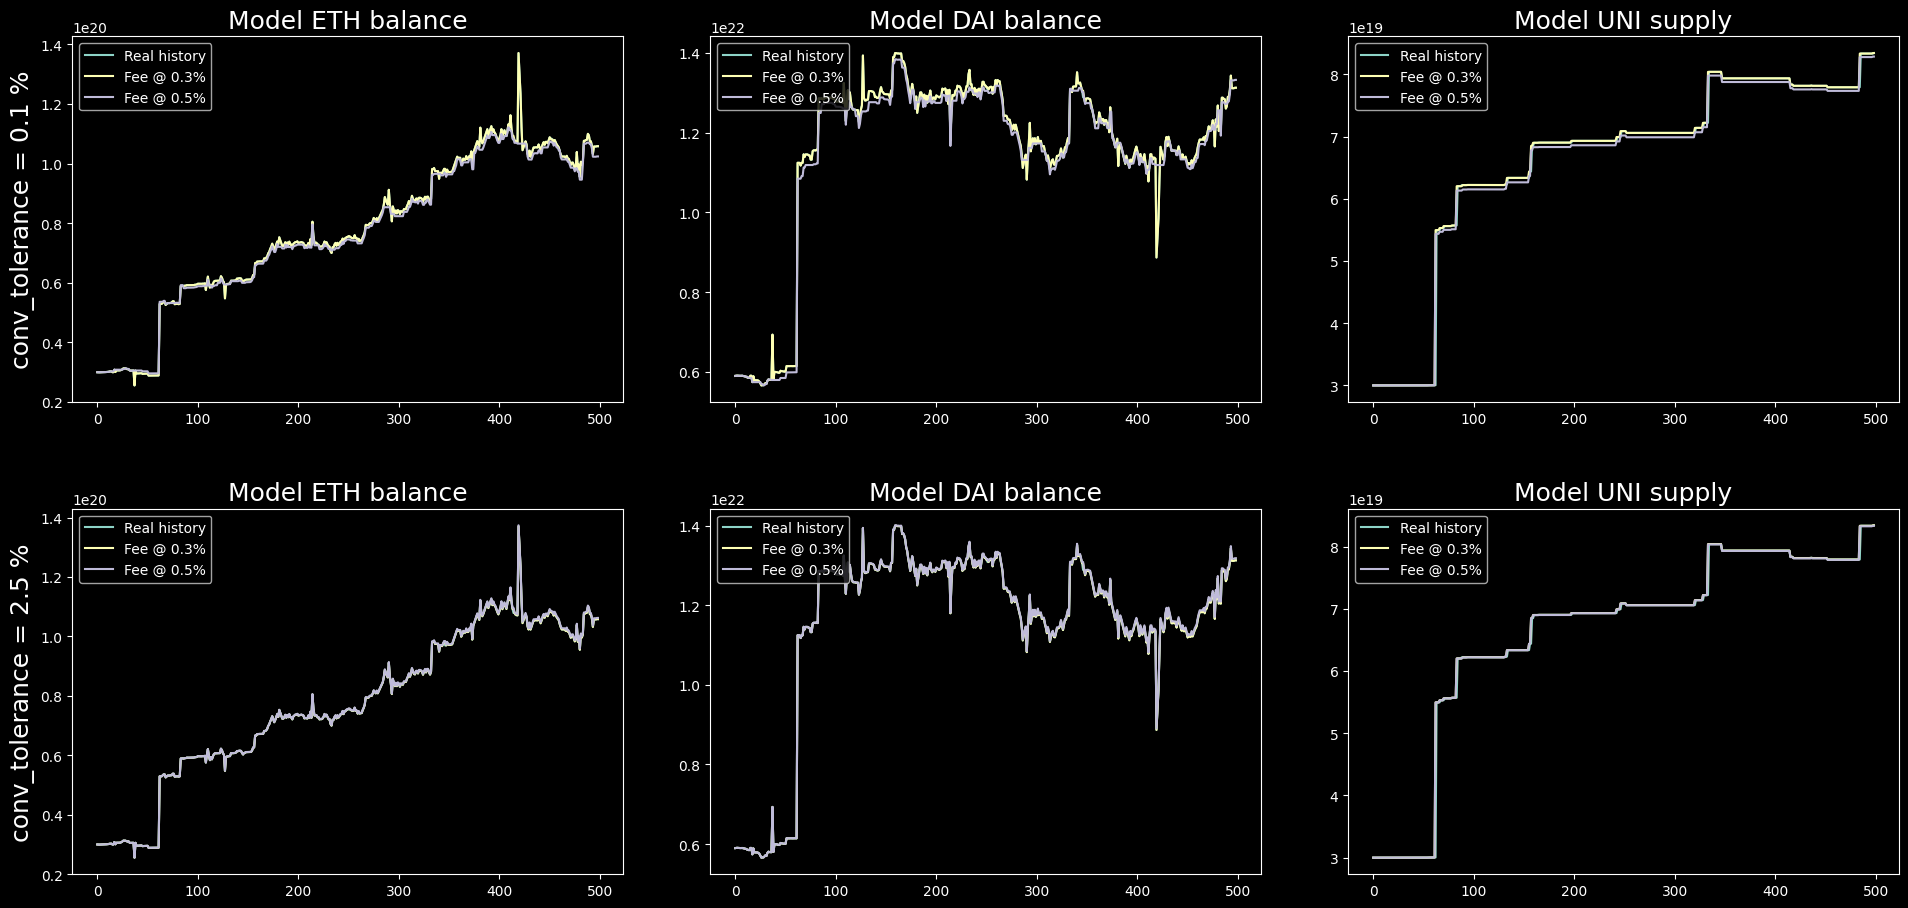

In [8]:
models = list()
for i in base_df['subset'].unique():
    models.append(base_df.loc[base_df['subset']==i,['DAI_balance', 'ETH_balance', 'UNI_supply']])
    
for df in models:
    df.columns = ['model_DAI_balance', 'model_ETH_balance', 'model_UNI_supply']
    df.reset_index(inplace=True)


nplots = len(set(fees))
nrows = len(set(retail_tols))
ncols = 3

fig, axs = plt.subplots(ncols = ncols, nrows = nrows, figsize=(20,10))

plt.close()

for i in range(nrows):
    axs[i][0].plot(real_history['real_ETH_balance'], label='Real history')
    axs[i][1].plot(real_history['real_DAI_balance'], label='Real history')
    axs[i][2].plot(real_history['real_UNI_supply'], label='Real history')
    axs[i][0].set_title('Model ETH balance', fontsize=18)
    axs[i][1].set_title('Model DAI balance', fontsize=18)
    axs[i][2].set_title('Model UNI supply', fontsize=18)
    axs[i][0].set_ylabel('conv_tolerance = {:.1f} %'.format(retail_tols[i]), fontsize=18)
    
    for k in range(nplots):
        axs[i][0].plot(models[nplots*nrows*k + i]['model_ETH_balance'],
                       label='Fee @ {:.1f}%'.format(fees[nplots*nrows*k + i]))
        axs[i][1].plot(models[nplots*nrows*k + i]['model_DAI_balance'],
                       label='Fee @ {:.1f}%'.format(fees[nplots*nrows*k + i]))
        axs[i][2].plot(models[nplots*nrows*k + i]['model_UNI_supply'],
                       label='Fee @ {:.1f}%'.format(fees[nplots*nrows*k + i]))

    for j in range(ncols):
        axs[i][j].legend(loc='upper left')

fig.tight_layout(pad=4.0)
fig

In [9]:
%%capture
df = base_df

prev_dai = pd.Series([np.nan]).append(df['DAI_balance'][:-1]).reset_index(drop=True)
prev_eth = pd.Series([np.nan]).append(df['ETH_balance'][:-1]).reset_index(drop=True)
df['delta_dai'] = df['DAI_balance'].diff()
df['delta_eth'] = df['ETH_balance'].diff()
df['istrade'] = (df['delta_dai'] > 0) != (df['delta_eth'] > 0)
df['volume'] = abs(df[df['istrade']]['delta_dai'])
df['volume'] = df['volume'].fillna(0)
df = df.drop(columns=['delta_dai','delta_eth','istrade'])
def ExpMovingAverage(values, window):
        weights = np.exp(np.linspace(-1., 0., window))
        weights /= weights.sum()
        a =  np.convolve(values, weights, mode='full')[:len(values)]
        a[:window] = a[window]
        return a

plot_data = base_df.copy()
plot_data[['DAI_balance',
           'ETH_balance',
           'UNI_supply',
           'volume']] = plot_data[['DAI_balance',
                                   'ETH_balance',
                                   'UNI_supply',
                                   'volume']]*1E-18
plot_data['ETH_price_DAI'] = plot_data['DAI_balance'] / plot_data['ETH_balance']
plot_data['UNI_price_DAI'] = 2 * plot_data['DAI_balance'] / plot_data['UNI_supply']

a = 0.5 * plot_data['ETH_price_DAI'][0] + 0.5 * plot_data['ETH_price_DAI']
plot_data['50_50_hodler_value'] = a.values

a = plot_data['50_50_hodler_value']/plot_data['50_50_hodler_value'][0] - 1
plot_data['50_50_hodler_return'] = a.values

a = plot_data['UNI_price_DAI']/plot_data['UNI_price_DAI'][0] - 1
plot_data['UNI_hodler_return'] = a.values

a = plot_data['ETH_price_DAI']/plot_data['ETH_price_DAI'][0] - 1
plot_data['ETH_hodler_return'] = a.values

plots = list()

for i in plot_data['subset'].unique():
    plots.append(plot_data[plot_data['subset'] == i])
for df in plots:
    df.reset_index(inplace=True)

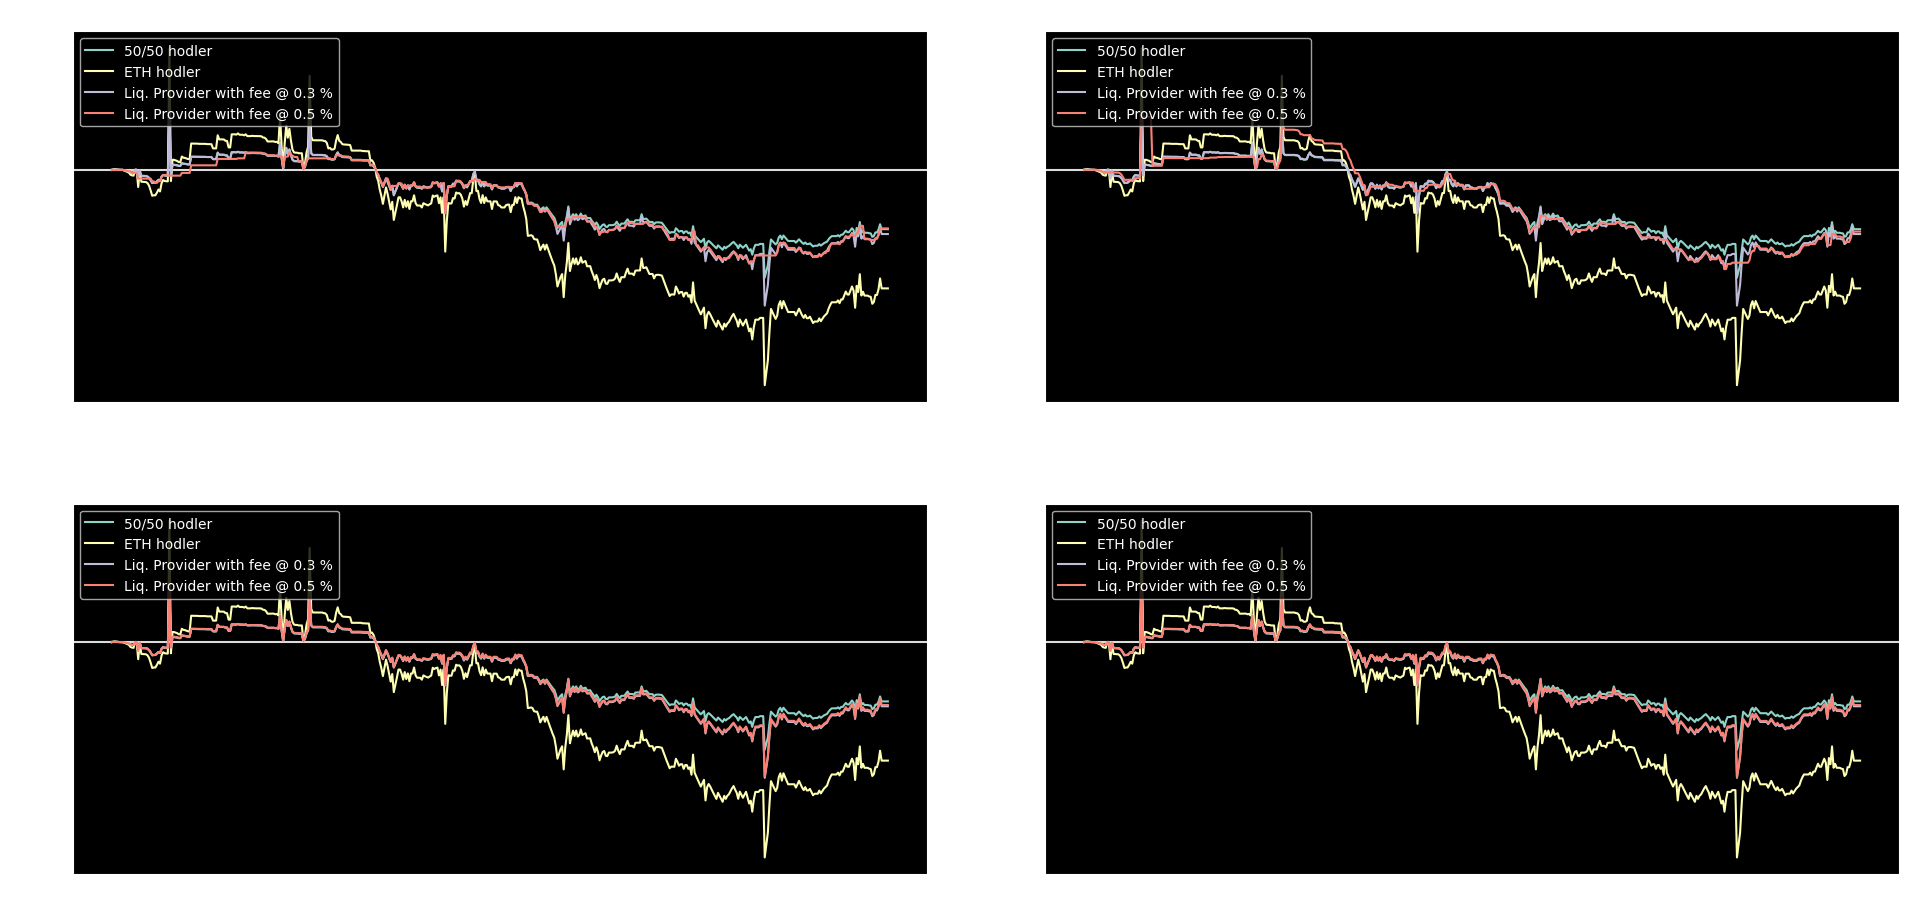

In [10]:
from IPython.display import HTML
from matplotlib import animation, rc
rc('animation', html='jshtml', embed_limit=50)
plt.rcParams['figure.facecolor'] = 'white'
from matplotlib import cm
import matplotlib.ticker as ticker

nplots = len(set(fees))
nrows = len(set(retail_tols))
ncols = len(set(retail_precision))

fig, axs = plt.subplots(ncols = ncols, nrows = nrows, figsize=(ncols*10,nrows*5))

plt.close()

if nrows > 1:
    for i in range(nrows):
        if ncols > 1:
            for j in range(ncols):
                axs[i][j].plot(plots[0]['50_50_hodler_return'], label=f'50/50 hodler')
                axs[i][j].plot(plots[0]['ETH_hodler_return'], label=f'ETH hodler')
                axs[i][j].axhline(0, color='gainsboro')
                axs[i][j].set_title(f'retail_precision = {retail_precision[ncols*j]}, retail_tolerance = {retail_tols[i]/100:.2%}')
                axs[i][j].set_ylabel('ROI')
                for k in range(nplots):
                    ema = ExpMovingAverage(plots[nplots*nrows*k + ncols*j + i]['UNI_hodler_return'], 1)
                    axs[i][j].plot(ema, label='Liq. Provider with fee @ {:.1f} %'.format(fees[nplots*nrows*k + ncols*j + i]))
            for j in range(ncols):
                axs[i][j].legend(loc='upper left')

fig.set_facecolor('white')
fig.tight_layout(pad=4.0)
fig